In [1]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib notebook

import numpy as np
from stingray.pulse.search import phase_dispersion_search
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)

# Phase Dispersion Minimization in Stingray

Phase dispersion minimization (PDM; Stellingwerf (1978)) is a method to search for strictly periodic signals in constant light curves (white noise only). Like Epoch Folding, it relies in folding a light curve at a given trial period, splitting the folded light curve into phase bins, and evaluating the resulting profile. 

Epoch Folding evaluates how much the means in each phase bin deviate from the global sample mean, given the variance of the measurements. A periodic signal will generate a maximum in the Epoch Folding periodogram across many trial periods. In contrast, Phase Dispersion Minimization evaluates the *variance* in each phase bin and compares this to the global sample variance $\hat{\sigma}$:

\begin{equation}
\theta_{\mathrm{PDM}} = \frac{1}{\hat{\sigma}} \frac{\sum_{ij}(x_{ij} - \bar{x}_j)^2}{N - M} \;
\end{equation}

for $N$ measurements in the light curve split into $M$ bins, and $\bar{x}_j$ the mean of measurements in bin $j$.

If a periodic signal is present in the data at a given trial period, the PDM statistic should have a *minimum* at that period.

## Simulate a dataset

Let us simulate a simple data set: we create a sinusoidal light curve and add Poisson noise:


In [2]:
def sinusoid(times, frequency, baseline, amplitude, phase):
    return baseline + amplitude * np.sin(2 * np.pi * (frequency * times + phase))

In [3]:
from stingray import Lightcurve

period = 1.203501
mean_countrate = 50
pulsed_fraction = 0.2
bin_time = 0.01
obs_length = 300

t = np.arange(0, obs_length, bin_time)

# The continuous light curve
counts = sinusoid(t, 1 / period, mean_countrate, 
                  0.5 * mean_countrate * pulsed_fraction, 0) * bin_time

counts = np.random.poisson(counts)

lc = Lightcurve(t, counts, gti=[[-bin_time / 2, obs_length + bin_time / 2]],
                dt=bin_time)

## Pulsation search with Phase Dispersion Minimization

Let us assume we have already an estimate of the true period, for example because we found a candidate in the power density spectrum with a period of ~1.2.
We search around that period with the phase dispersion minimization.

The first thing we need to do is *fold* the light curve: for every data point, we convert the time of that bin to its corresponding phase. We then split the resulting phase-folded light curve into $M$ phase bins, where $M$ should strike a balance between generating enough bins to accurately represent the structure in the phase curve, but also few enough bins that the number of measurements in each bin is meaningful.

In regular epoch folding, we calculate the mean flux (or counts) within each bin as a useful statistic. Let's do that first, because it gives us a nice visual representation. Note that when using a light curve (rather than event arrival times) in `fold_events`, you need to use set the `weights` keyword to the array of fluxes or counts:

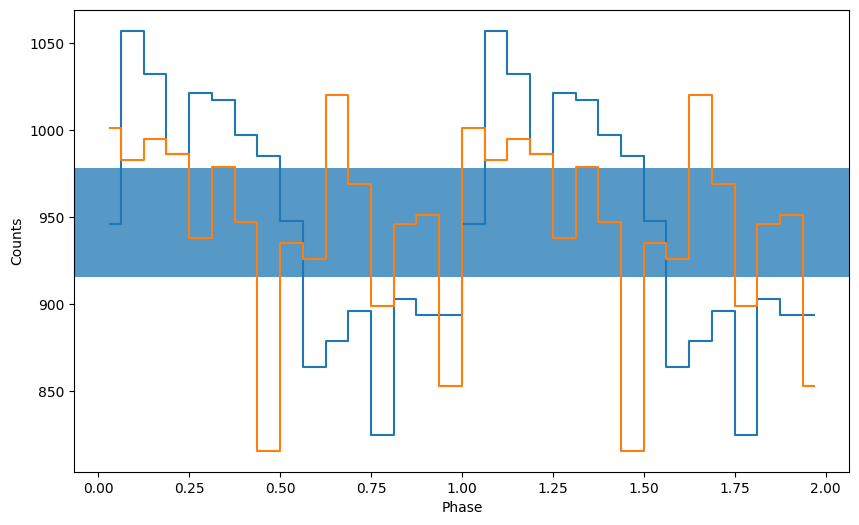

In [4]:
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile
nbin = 16

ph, profile, profile_err = fold_events(lc.time, 1/period, nbin=nbin, weights=lc.counts)
_ = plot_profile(ph, profile)

ph, profile, profile_err = fold_events(lc.time, 1/1.1, nbin=nbin, weights=lc.counts)
_ = plot_profile(ph, profile)

As you can see, folding at the correct period (blue line) generates a profile that looks approximately sinusoidal, whereas folding at a different period (orange line) does not. 

For Phase Dispersion Minimization, we are not interested in the *mean* in each phase bin, but rather the *variance* in each phase bin, which we'd like to _minimize_, not maximize. We can also calculate that using `fold_profile`, using `mode="pdm"` (the default is Epoch Folding, `mode="ef"`):


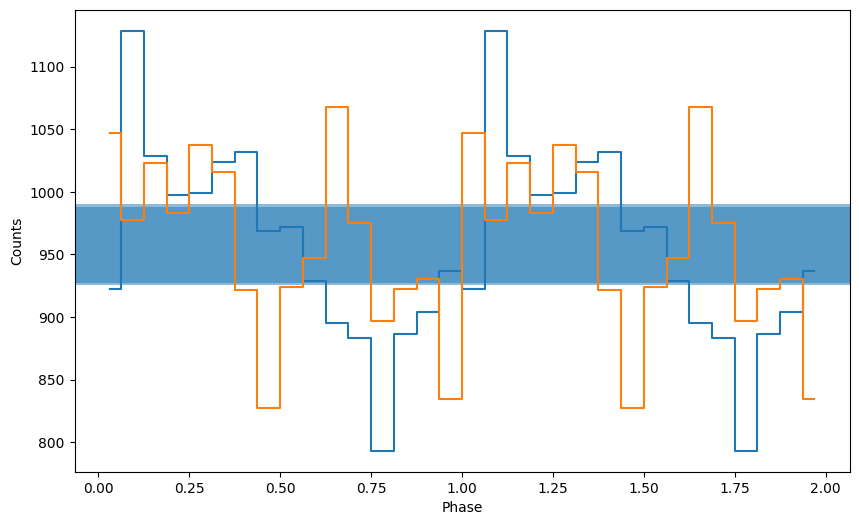

In [5]:
ph, profile, profile_err = fold_events(lc.time, 1/period, nbin=nbin, weights=lc.counts, mode="pdm")
_ = plot_profile(ph, profile)

ph, profile, profile_err = fold_events(lc.time, 1/1.1, nbin=nbin, weights=lc.counts, mode="pdm")
_ = plot_profile(ph, profile)

As you can see, this looks very different, and not quite as easily recognizeable. What you see here is the nominator of the second term in the PDM Equation written in the introduction.

We'd now like to try calculating this profile for a number of trial periods, and then calculate $\theta_\mathrm{PDM}$. Our null hypothesis is that there is no variation in the data except for measurement noise (e.g. Poisson statistics as we have here, or Gaussian noise). This is implemenented in `stingray.pulse.search.phase_dispersion_search`.

For the frequency resolution of the periodogram, one usually chooses _at least_ the same frequency resolution of the FFT, i. e., $df_{\rm min}=1/(t_1 - t_0)$. In most cases, a certain degree of oversampling is used.

Let's do that:

In [6]:
# We will search for pulsations over a range of frequencies around the known pulsation period.
df_min = 1/obs_length
oversampling=15
df = df_min / oversampling
frequencies = np.arange(1/period - 200 * df, 1/period + 200 * df, df)

freq, pdmstat = phase_dispersion_search(lc.time, lc.counts, frequencies, nbin=nbin)

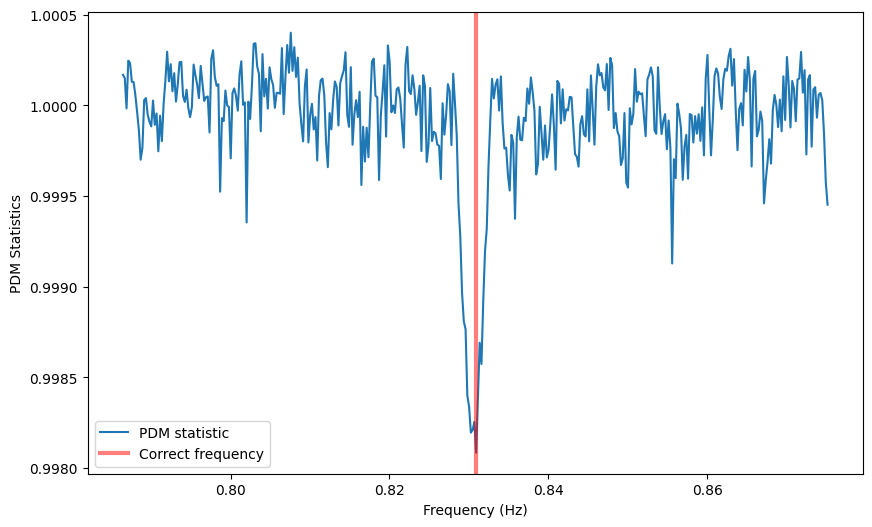

In [7]:
# ---- PLOTTING --------
plt.figure()
plt.plot(freq, pdmstat, label='PDM statistic')
#plt.axhline(nbin - 1, ls='--', lw=3, color='k', label='n - 1')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PDM Statistics')
_ = plt.legend()

A dip is definitely there at the frequency we expect it to be. 

Unlike the Epoch Folding statistic, which follows approximately a $\chi^2$ distribution, the PDM statistic was shown to follow a beta-distribution (Schwarzenberg-Czerny, 1997). 

We can use this beta-distribution to calculate the significance of a peak found in the PDM periodogram, or to set a detection threshold. In stingray, this is implemented in the `stingray.stats` module, using `stingray.stats.phase_dispersion_detection_level` and `stingray.stats.phase_dispersion_probability`:



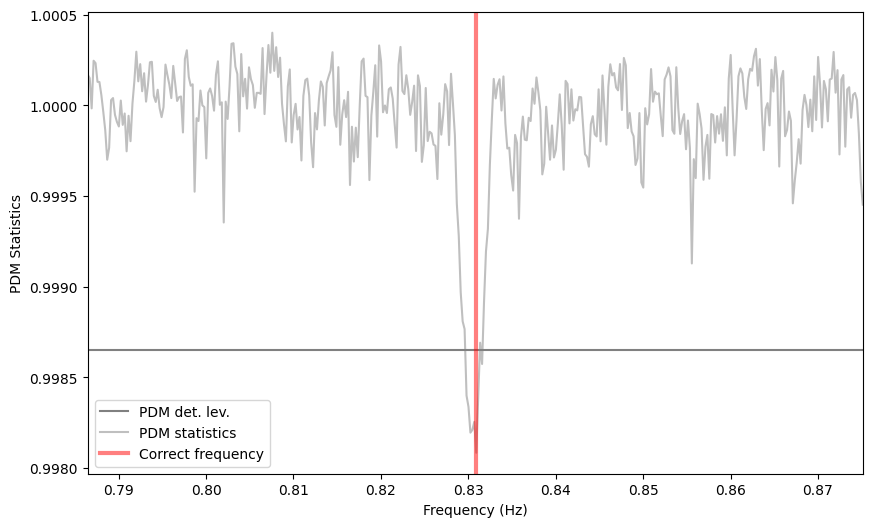

In [8]:
from stingray.stats import phase_dispersion_detection_level, phase_dispersion_probability

# number of trials (the number of independent frequencies)
# we searched over
ntrial = int((frequencies[-1] - frequencies[0]) / df_min)

# number of time bins in the light curve
nsamples = len(lc.time)

pdm_det_level = phase_dispersion_detection_level(nsamples, nbin, epsilon=0.01, ntrial=ntrial)

# ---- PLOTTING --------
plt.figure()
plt.axhline(pdm_det_level, label='PDM det. lev.', color='gray')

plt.plot(freq, pdmstat, color='gray', label='PDM statistics', alpha=0.5)

#for c in cand_freqs_ef:
#    plt.axvline(c, ls='-.', label='EF Candidate', zorder=10)
#for c in cand_freqs_z:
#    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)
    
plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PDM Statistics')
plt.legend()


Let's also calculate the significance of the deepest dip:

In [9]:
min_idx = np.argmin(pdmstat)

pval = phase_dispersion_probability(pdmstat[min_idx], nsamples, nbin, ntrial=ntrial)

print(f"The probability of the minimum at {freq[min_idx]} Hz is: p = {pval}")

The probability of the minimum at 0.830909155871082 Hz is: p = 1.7270421255248036e-05
